In [143]:
import sqlite3 as sq
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import os

In [3]:
conn = sq.connect("../crowd.sqlite")

In [4]:
def list_tables(conn, filter_str: str = ""):
    with conn:
        tables = conn.execute("SELECT name FROM main.sqlite_master WHERE type='table'").fetchall();
    return list(filter(lambda t: t.find(filter_str) != -1, map(lambda t: t[0], tables)))

In [7]:
ballistic_tables = list_tables(conn, "fit_ballistic")
brownian_tables = list_tables(conn, "fit_brownian")

In [23]:
def get_table(conn, tables, isf = "brownian"):
    data = {t.replace(f"fit_{isf}_video_multiDDM", isf): {} for t in tables}
    for table in tables:
        table_name = table.replace(f"fit_{isf}_video_multiDDM", isf)
        with conn:
            raw_data = conn.execute(f"select * from {table}").fetchall()
        for d in raw_data:
            if isf == "brownian":
                _, box_size, q, tauc, _, A, _, B, _ = d
                try:
                    data[table_name][box_size][q] = (tauc, A, B)
                except KeyError:
                    data[table_name][box_size] = {q: (tauc, A, B)}
            else:
                _, box_size, q, tauc, _, v, _, A, _, B, _ = d
                try:
                    data[table_name][box_size][q] = (tauc, v, A, B)
                except KeyError:
                    data[table_name][box_size] = {q: (tauc, v, A, B)}
    return data
                
                

In [25]:
brownian_data = get_table(conn, brownian_tables)
ballistic_data = get_table(conn, ballistic_tables, "ballistic")

In [57]:
valid_keys = brownian_data[list(brownian_data.keys())[0]].keys()

dict_keys([64, 81, 108, 135, 162, 216, 243, 288, 360, 405, 486, 540, 640, 729, 810, 1024])

In [94]:
def plot(data, box_size, param_name: str, param=0, vid=None):
    if vid is None:
        for name, dat in data.items():
            valid_box_sizes = list(dat.keys())
            closest_boxsize = valid_box_sizes[np.argmin(list(map(lambda x: abs(x - box_size), valid_box_sizes)))]
            x = list(dat[closest_boxsize].keys())
            y = list(map(lambda x: x[param], dat[closest_boxsize].values()))
            plt.title(f"All videos for boxsize = {closest_boxsize} pixels")
            plt.xlabel("log(q / pixel size)")
            plt.ylabel(f"log({param_name})")
            plt.plot(np.log(x), np.log(y))
    else:
        name = vid
        dat = data[name]
        valid_box_sizes = list(dat.keys())
        closest_boxsize = valid_box_sizes[np.argmin(list(map(lambda x: abs(x - box_size), valid_box_sizes)))]
        x = list(dat[closest_boxsize].keys())
        y = list(map(lambda x: x[param], dat[closest_boxsize].values()))
        plt.title(f"video = {name} for boxsize = {closest_boxsize} pixels")
        plt.xlabel("log(q / pixel size)")
        plt.ylabel(f"log({param_name})")
        plt.plot(np.log(x), np.log(y))


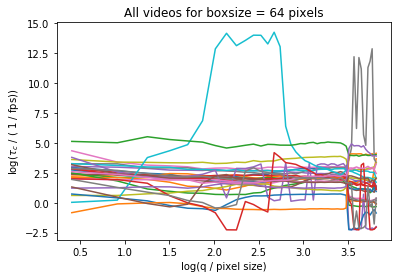

In [89]:
plot(brownian_data, 52, r"$\tau_c$ / ( 1 / fps)", 0)

In [150]:
def plot_over_box_size(data, param_name: str, param=0, vid=None, fname=None):
    name = vid
    dat = data[name]
    for boxsize in dat.keys():
        x = list(data[name][boxsize].keys())
        y = list(map(lambda x: x[param], data[name][boxsize].values()))
        plt.title(f"{param_name} vs q / pixel size for {name} at all box sizes")
        plt.xlabel("log(q / pixel size)")
        plt.ylabel(f"log({param_name})")
        plt.plot(np.log(x), np.log(y), label=f"{boxsize} pixels")
    plt.legend(loc="best", bbox_to_anchor=(1.45, 1.08))
    if fname is not None:
        plt.savefig(fname, dpi=300, pad_inches=0.8, bbox_inches = "tight")
    plt.close()


In [152]:
plot_over_box_size(brownian_data, r"$\tau_c$ / (1 / fps)", 0, "brownian_crowd15")

In [153]:
def save_all_over_boxsize(data, directory: str, param_name: str, param=0):
    if not os.path.exists(directory):
        os.mkdir(directory)
    for name in data.keys():
        output = f"{directory}/{name}_all_boxsizes.png"
        if os.path.exists(output):
            continue
        plot_over_box_size(data, param_name, param, name, output)
    

In [156]:
save_all_over_boxsize(brownian_data, "all_boxsizes_brownian_tauc", r"$\tau_c$ / (1 / fps)", 0)
save_all_over_boxsize(brownian_data, "all_boxsizes_brownian_A", r"A / $grayscale^2$", 1)
save_all_over_boxsize(brownian_data, "all_boxsizes_brownian_B", r"B / $grayscale^2$", 2)

In [157]:
save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_tauc", r"$\tau_c$ / (1 / fps)", 0)
save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_v", r"v / ($fps \cdot pixel$ $size$)", 1)
save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_A", r"A / $grayscale^2$", 2)
save_all_over_boxsize(ballistic_data, "all_boxsizes_ballistic_B", r"B / $grayscale^2$", 3)

/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
